# Forecast users next exercise and duration of exercise using smart watch data

#### By: Maaz Tariq Bhatti

# Data exploratory analysis

This section of the analysis will contain scripts to load the dataset and then perform exploratory analysis inorder to better understand the data structure.

The dataset is available in json format. The dataset contains records of one person from sports tracking software Endomondo. It has 3456 events which translate to the rows of our dataset. Each event is a structure containing 15 variables. While the first 14 variables are singular values of different data types the last variable(15) by the name "points" is another structure containing further event information. This structure within a structure contains location, speed and distance covered information during the specific exercise at multiple time stamps. Most of these data points are already aggregated in the main table such as speed,distance etc. 

In order to keep our dataset simple we keep it in the form of a 2 dimensional table. The location information stored in this simple table format will be scalar values. We extract the starting and ending longitude/latitudes from the "points" structure as the high level information for our dataset.

We start by loading the dependencies

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from read_file_to_df import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

Next we provide the path of the dataset and load it. (The read_file_to_df function is in a seperate file).

In [2]:
# Settings
folder = 'WorkoutData_2017to2020'
file_list = os.listdir(folder)

# Create Empty DataFrame
df_res = pd.DataFrame()

# Read files to a common dataframe
for filename in file_list:
    #print('/n'+filename)
    df_process = read_file_to_df(folder +"/"+ filename)
    df_res = pd.concat([df_res, df_process])

df_res.reset_index(drop=True, inplace = True)

Display top rows of the dataset in order to get an understanding of it 

In [3]:
df_res.head()

,sport,source,created_date,start_time,end_time,duration_s,distance_km,calories_kcal,altitude_min_m,altitude_max_m,speed_avg_kmh,speed_max_kmh,ascend_m,descend_m,start_lat,start_long,end_lat,end_long,hydration_l
0,WALKING,TRACK_MOBILE,2017-05-13 14:02:55.0,2017-05-13 14:01:50.0,2017-05-13 14:37:51.0,2160,2.910000,209.2250,118.000,213.500,4.850000,7.2000,198.500,183.000,64.231913,27.729532,64.231913,27.729532,NaN
1,WALKING,TRACK_MOBILE,2018-04-06 06:16:11.0,2018-04-06 06:16:10.0,2018-04-06 06:41:18.0,1507,2.238073,178.0000,162.838,235.334,5.346425,10.4055,356.057,370.696,64.231726,27.729664,64.231726,27.729664,0.099905
2,WALKING,TRACK_MOBILE,2017-11-13 04:18:37.0,2017-11-13 04:16:17.0,2017-11-13 04:34:04.0,1066,1.090000,87.6835,137.500,210.500,3.681051,6.3000,62.500,71.000,64.231804,27.729534,64.231804,27.729534,NaN
3,WALKING,TRACK_MOBILE,2017-05-27 06:43:58.0,2017-05-27 06:09:17.0,2017-05-27 06:43:17.0,2040,2.860000,214.7170,118.000,158.000,5.047059,8.1000,69.000,70.000,64.231613,27.729586,64.231613,27.729586,NaN
4,CYCLING_SPORT,TRACK_MOBILE,2017-07-23 14:46:45.0,2017-07-23 14:45:00.0,2017-07-23 15:11:10.0,1569,8.090000,306.2000,120.000,173.000,18.562141,39.6000,51.500,54.000,64.220878,27.671177,64.220878,27.671177,NaN


Lets take a look at the summary statistics of the numerical variables

In [4]:
df_res.describe()

,duration_s,distance_km,calories_kcal,altitude_min_m,altitude_max_m,speed_avg_kmh,speed_max_kmh,ascend_m,descend_m,start_lat,start_long,end_lat,end_long,hydration_l
count,3456.000000,3456.000000,3455.000000,3048.000000,3048.000000,3456.000000,3043.000000,3045.000000,3045.000000,3042.000000,3042.000000,3042.000000,3042.000000,2534.000000
mean,2259.405961,3.006154,273.606885,137.234690,197.367589,4.884332,13.926859,96.053425,98.858494,63.906194,27.466158,63.906194,27.466158,0.154937
std,1208.975319,2.448839,181.303151,40.914059,34.045762,5.143595,27.954310,133.437502,133.384458,1.984757,2.176164,1.984757,2.176164,0.090523
min,7.000000,0.000000,1.000000,-500.500000,0.000000,0.000000,3.600000,0.000000,0.000000,40.761649,-0.375375,40.761649,-0.375375,0.000203
25%,1500.000000,1.676724,158.000000,132.841500,181.352750,4.109752,8.334020,47.864000,52.290000,64.231720,27.729426,64.231720,27.729426,0.093130
50%,2035.500000,2.494822,219.000000,145.422000,205.628000,4.798089,9.838770,74.500000,75.679900,64.231803,27.729544,64.231803,27.729544,0.132489
75%,2734.250000,3.702019,336.000000,161.576500,220.089250,5.269469,12.315600,112.649000,114.583000,64.231875,27.729684,64.231875,27.729684,0.189570
max,16742.000000,35.498642,1540.000000,283.500000,444.000000,267.428562,682.219000,4415.000000,4294.500000,68.909689,29.648962,68.909689,29.648962,0.769048


### Dealing with null values 

Next we take a look at the missing values for each column. This information will be valuable when performing feature engineering for the predictive model. We will make decisions based which column to include and use for feature engineering based on the null values in these columns

In [5]:
print(df_res.isnull().sum())

sport               0
source              0
created_date        0
start_time          0
end_time            0
duration_s          0
distance_km         0
calories_kcal       1
altitude_min_m    408
altitude_max_m    408
speed_avg_kmh       0
speed_max_kmh     413
ascend_m          411
descend_m         411
start_lat         414
start_long        414
end_lat           414
end_long          414
hydration_l       922
dtype: int64


We notice that altitude_min_m and altitude_max_m have the same number of null values which may indicate that when one of these variables is null the other is null aswell. Lets take a look at the rows with altitude_max_m = null.

In [6]:
df_res[df_res['speed_max_kmh'].isnull()].head()

,sport,source,created_date,start_time,end_time,duration_s,distance_km,calories_kcal,altitude_min_m,altitude_max_m,speed_avg_kmh,speed_max_kmh,ascend_m,descend_m,start_lat,start_long,end_lat,end_long,hydration_l
8,WEIGHT_TRAINING,TRACK_MOBILE,2020-05-09 15:37:53.0,2020-05-09 15:36:29.0,2020-05-09 16:05:35.0,1745,0.0,290.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.152267
10,WEIGHT_TRAINING,INPUT_MANUAL_MOBILE,2020-01-22 18:01:18.0,2020-01-21 18:00:39.0,2020-01-21 18:45:39.0,2700,0.0,447.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.235600
17,WEIGHT_TRAINING,INPUT_MANUAL_MOBILE,2017-04-11 14:48:07.0,2017-04-11 11:47:00.0,2017-04-11 12:32:00.0,2700,0.0,442.5,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,WEIGHT_TRAINING,TRACK_MOBILE,2020-11-20 18:23:06.0,2020-11-20 18:22:03.0,2020-11-20 19:02:57.0,2452,0.0,407.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.213872
22,SWIMMING,INPUT_MANUAL_MOBILE,2018-02-27 13:08:30.0,2018-02-27 13:08:07.0,2018-02-27 13:38:07.0,1800,1.2,400.0,NaN,NaN,2.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.204220


Now we see that our guess was correct. It makes sense that the altitude values are null because the sports corresponding to these rows are such that do not require moving upwards or downwards. The same is the case with speed_max_kmh. There is no need to calculate speed for exercises like Weight training. We can therefore convert these values to 0 instead of keeping them as null values. The same logic applies to ascend_m and descend_m.

Conversion of null values to 0 so the columns can be utilized in the predictive model.

In [7]:
df_res['speed_max_kmh'].fillna(0, inplace=True)
df_res['altitude_min_m'].fillna(0, inplace=True)
df_res['altitude_max_m'].fillna(0, inplace=True)
df_res['ascend_m'].fillna(0, inplace=True)
df_res['descend_m'].fillna(0, inplace=True)

Since we do not have much knowledge about the variable hydration_l and it has many null values we will remove this column


In [8]:
df_res = df_res.drop(columns=['hydration_l'])

There is still a null value left in the calories_kcal. Lets take a look at that row

In [9]:
df_res[df_res['calories_kcal'].isnull()]

,sport,source,created_date,start_time,end_time,duration_s,distance_km,calories_kcal,altitude_min_m,altitude_max_m,speed_avg_kmh,speed_max_kmh,ascend_m,descend_m,start_lat,start_long,end_lat,end_long
2761,WALKING,INPUT_MANUAL_MOBILE,2020-08-22 07:35:24.0,2020-08-22 07:35:03.0,2020-08-22 07:35:10.0,7,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


It is safe to say that since the duration of this workout is only 7 seconds with all other metrics as 0 we can convert this null value to 0 aswell. Then we print the null values contained in the dataset to make sure none exist.

In [10]:
df_res['calories_kcal'].fillna(0, inplace=True)
print(df_res.isnull().sum())

sport               0
source              0
created_date        0
start_time          0
end_time            0
duration_s          0
distance_km         0
calories_kcal       0
altitude_min_m      0
altitude_max_m      0
speed_avg_kmh       0
speed_max_kmh       0
ascend_m            0
descend_m           0
start_lat         414
start_long        414
end_lat           414
end_long          414
dtype: int64


Now we notice that the only variables with null values remaining in the dataset are the location information. Start and end points. We cannot set these values to 0 since it can be translated into meaning information for the location of the person. And these null values are not low in number so removing these rows will be a poor approach. We will move on without these variables and utilize the remaining variables for feature engineering.

In [11]:
df_res = df_res.drop(columns=['start_lat','start_long','end_lat','end_long'])

### Categorical variable analysis

It can be seen that the first 2 variables seem to be categorical variables. Lets take a look into the unique categories available in these variables 

#### Unique sports activites

In [12]:
# Extract unique categories in the 'Sport' column
unique_sports = df_res['sport'].unique()

# Print the unique categories
for sport in unique_sports:
    print(sport)
    
print("Total sports:", len(unique_sports))

WALKING
CYCLING_SPORT
WEIGHT_TRAINING
SKIING_CROSS_COUNTRY
SWIMMING
CROSSFIT
RUNNING
STAIR_CLIMBING
RUNNING_CANICROSS
BADMINTON
ICE_SKATING
CROSS_TRAINING
CYCLING_TRANSPORTATION
ROLLER_SKATING
STRETCHING
BEACH_VOLLEY
FITNESS_WALKING
Total sports: 17


####  Unique sources

In [13]:
# Extract unique categories in the 'Source' column
unique_source = df_res['source'].unique()

# Print the unique categories
for source in unique_source:
    print(source)

print("Total sources:", len(unique_source))

TRACK_MOBILE
INPUT_MANUAL_MOBILE
Total sources: 2


We see that there are 17 unique sports modes and 2 different sources

Next lets take a look at the distribution of the distance covered and average speed during each activity

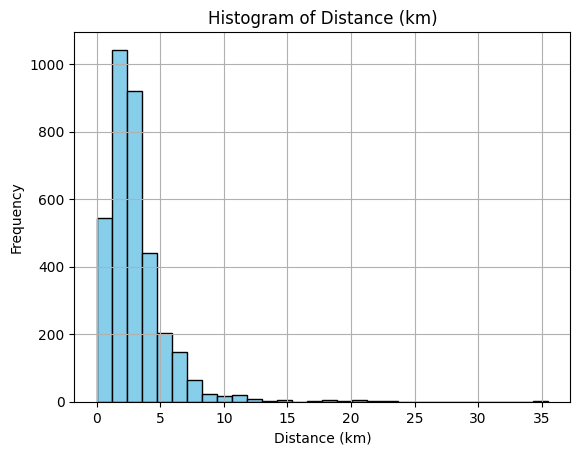

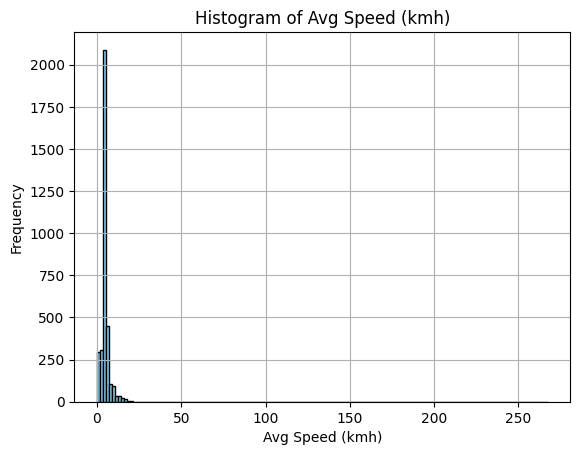

In [14]:
# Extract the 'distance_km' column for the histogram
distance_data = df_res['distance_km']

# Create a histogram
plt.hist(distance_data, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.title('Histogram of Distance (km)')
plt.grid(True)

# Show the histogram
plt.show()
# Extract the 'distance_km' column for the histogram
speed_avg = df_res['speed_avg_kmh']

# Create a histogram
plt.hist(speed_avg, bins=150, color='skyblue', edgecolor='black')
plt.xlabel('Avg Speed (kmh)')
plt.ylabel('Frequency')
plt.title('Histogram of Avg Speed (kmh)')
plt.grid(True)

# Show the histogram
plt.show()

The histograms give us the insight that the user moves between 1-4 km the most during their exercise. While the average speed for many exercises is 0. They probably do not require moving from one place to another. Then the graph peaks at around 4-8 km/h. This makes sense as the user walks quite alot and this is average speed a human walks on. 

# Feature Engineering

For this section of our analysis we will be extracting new variables from existing columns that can prove to be benificial as predictors in the predictive model. The following new features are added to the dataset

#### Weekday

In [15]:
# Convert the "created_date" column to a datetime object
df_res['created_date'] = pd.to_datetime(df_res['created_date'])

# Extract the weekday from the datetime
df_res['weekday'] = df_res['created_date'].dt.strftime('%A')

# Display the first few rows with the added 'weekday' column
df_res[['created_date', 'weekday']].head()


,created_date,weekday
0,2017-05-13 14:02:55,Saturday
1,2018-04-06 06:16:11,Friday
2,2017-11-13 04:18:37,Monday
3,2017-05-27 06:43:58,Saturday
4,2017-07-23 14:46:45,Sunday


#### Month

In [16]:
# Extract the month from the datetime
df_res['month'] = df_res['created_date'].dt.month

# Display the first few rows with the added 'month' column
df_res[['created_date', 'month']].head()

,created_date,month
0,2017-05-13 14:02:55,5
1,2018-04-06 06:16:11,4
2,2017-11-13 04:18:37,11
3,2017-05-27 06:43:58,5
4,2017-07-23 14:46:45,7


#### Time of day

In [17]:

# Convert the "start_time" column to a datetime object
df_res['start_time'] = pd.to_datetime(df_res['start_time'])

# Extract the hour from the "start_time" column
df_res['start_hour'] = df_res['start_time'].dt.hour

# Create a function to categorize the time of day
def categorize_time(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 20:
        return 'Evening'
    else:
        return 'Night'

# Apply the categorize_time function to create a new variable
df_res['time_of_day'] = df_res['start_hour'].apply(categorize_time)

# Display the updated DataFrame
df_res[['start_time', 'start_hour', 'time_of_day']].head()

,start_time,start_hour,time_of_day
0,2017-05-13 14:01:50,14,Afternoon
1,2018-04-06 06:16:10,6,Morning
2,2017-11-13 04:16:17,4,Night
3,2017-05-27 06:09:17,6,Morning
4,2017-07-23 14:45:00,14,Afternoon


## Dependent variables for predictive model

#### Next Exercise type

In order to predict the next exercise type we will first order the dataset in ascending order according to the created_date column. Then we will be able to see the next available exercise type in the row below

In [18]:
# Sort the dataset in ascending order by "created_date"
df_res = df_res.sort_values(by="created_date")

# Display the sorted dataset
df_res[['sport', 'created_date']].head()

,sport,created_date
937,WALKING,2017-01-01 08:54:23
1448,WEIGHT_TRAINING,2017-01-01 15:02:04
771,WALKING,2017-01-01 17:47:03
509,WALKING,2017-01-02 08:57:23
2718,RUNNING,2017-01-02 16:20:51


Now the next exercise for the first row is "WEIGHT_TRAINING" 

In [19]:
# Create a new column "Next_Sport" with values from the next row
df_res['Next_Sport'] = df_res['sport'].shift(-1)

# Set the last entry in "Next_Sport" to an empty string
df_res.at[len(df_res) - 1, 'Next_Sport'] = ''

#### Next exercise Time

In [20]:
# Create a new column "Next_Sport" with values from the next row
df_res['Next_Sport_Time'] = df_res['time_of_day'].shift(-1)

# Set the last entry in "Next_Sport" to an empty string
df_res.at[len(df_res) - 1, 'Next_Sport_Time'] = ''
df_res.head()

,sport,source,created_date,start_time,end_time,duration_s,distance_km,calories_kcal,altitude_min_m,altitude_max_m,speed_avg_kmh,speed_max_kmh,ascend_m,descend_m,weekday,month,start_hour,time_of_day,Next_Sport,Next_Sport_Time
937,WALKING,TRACK_MOBILE,2017-01-01 08:54:23,2017-01-01 08:53:04,2017-01-01 09:27:49.0,2084,2.15,171.651,145.5,198.0,3.714012,6.3,78.0,77.0,Sunday,1,8,Morning,WEIGHT_TRAINING,Afternoon
1448,WEIGHT_TRAINING,INPUT_MANUAL_MOBILE,2017-01-01 15:02:04,2017-01-01 14:01:00,2017-01-01 14:41:00.0,2400,0.00,393.333,0.0,0.0,0.000000,0.0,0.0,0.0,Sunday,1,14,Afternoon,WALKING,Evening
771,WALKING,TRACK_MOBILE,2017-01-01 17:47:03,2017-01-01 17:46:00,2017-01-01 18:12:07.0,1566,1.69,132.168,126.5,174.5,3.885057,5.4,28.0,34.5,Sunday,1,17,Evening,WALKING,Morning
509,WALKING,TRACK_MOBILE,2017-01-02 08:57:23,2017-01-02 08:55:52,2017-01-02 09:26:06.0,1812,2.07,157.828,81.0,201.0,4.112583,6.3,119.5,47.5,Monday,1,8,Morning,RUNNING,Afternoon
2718,RUNNING,TRACK_MOBILE,2017-01-02 16:20:51,2017-01-02 16:13:34,2017-01-02 16:54:52.0,2444,5.87,591.404,97.5,159.5,8.646481,12.6,137.5,140.5,Monday,1,16,Afternoon,WALKING,Morning


Since the last row of the new predictor columns will be empty we will remove the last row as the next activity information is not available

In [21]:
df_res = df_res.drop(df_res[df_res['Next_Sport'] == ''].index)
df_res = df_res.dropna(subset = ['Next_Sport'])

In [22]:
df_res[df_res['Next_Sport'].isnull()]

,sport,source,created_date,start_time,end_time,duration_s,distance_km,calories_kcal,altitude_min_m,altitude_max_m,speed_avg_kmh,speed_max_kmh,ascend_m,descend_m,weekday,month,start_hour,time_of_day,Next_Sport,Next_Sport_Time


Now that we have all the features, we will proceed to the predictive modelling section. However proceeding we make our dataset tidy so that it only contains relavent features required in the modelling phase. We now select the columns to keep and create a new dataset from these columns. 

In [23]:
columns_to_keep = ['sport', 'source', 'duration_s','distance_km','calories_kcal','altitude_min_m','altitude_max_m', 'speed_avg_kmh', 'speed_max_kmh', 'ascend_m', 'descend_m','weekday','month','start_hour','time_of_day','Next_Sport','Next_Sport_Time'] 
data = df_res[columns_to_keep]
data.shape

(3454, 17)

# Predictive modelling and evaluation

Before proceeding lets take a look at the dataset that will be used for predictive modelling. Next_Sport and Next_Sport_Time are the response variables. We will be using the random forest classifier to predict the next sport and next time of sport aswell.

In [24]:
data.head()

,sport,source,duration_s,distance_km,calories_kcal,altitude_min_m,altitude_max_m,speed_avg_kmh,speed_max_kmh,ascend_m,descend_m,weekday,month,start_hour,time_of_day,Next_Sport,Next_Sport_Time
937,WALKING,TRACK_MOBILE,2084,2.15,171.651,145.5,198.0,3.714012,6.3,78.0,77.0,Sunday,1,8,Morning,WEIGHT_TRAINING,Afternoon
1448,WEIGHT_TRAINING,INPUT_MANUAL_MOBILE,2400,0.00,393.333,0.0,0.0,0.000000,0.0,0.0,0.0,Sunday,1,14,Afternoon,WALKING,Evening
771,WALKING,TRACK_MOBILE,1566,1.69,132.168,126.5,174.5,3.885057,5.4,28.0,34.5,Sunday,1,17,Evening,WALKING,Morning
509,WALKING,TRACK_MOBILE,1812,2.07,157.828,81.0,201.0,4.112583,6.3,119.5,47.5,Monday,1,8,Morning,RUNNING,Afternoon
2718,RUNNING,TRACK_MOBILE,2444,5.87,591.404,97.5,159.5,8.646481,12.6,137.5,140.5,Monday,1,16,Afternoon,WALKING,Morning


Lets deal with the categorical variables using one hot encoding technique

In [25]:
# # Encoding categorical variables (e.g., one-hot encoding for 'time_of_day' and 'weekday')
data = pd.get_dummies(data, columns=['time_of_day', 'weekday','sport','source'], drop_first=True)

In [26]:
# Define the features (X) and the target variables (y)
X = data.drop(['Next_Sport', 'Next_Sport_Time'], axis=1)
y_next_sport = data['Next_Sport']
y_next_sport_time = data['Next_Sport_Time']

Next we split the dataset into 70% training and 30% testing.

In [27]:

X_train, X_test, y_next_sport_train, y_next_sport_test, y_next_sport_time_train, y_next_sport_time_test = train_test_split(
    X, y_next_sport, y_next_sport_time, test_size=0.3,random_state=42
)
     

#### Random Forest implementation for Next_Sport

In [28]:
rf_classifier_next_sport = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_next_sport.fit(X_train, y_next_sport_train)

# Predict 'Next_Sport' on the test set
y_next_sport_pred = rf_classifier_next_sport.predict(X_test)

Model analysis

In [29]:
# Evaluate the models
print("Accuracy for Next_Sport:", accuracy_score(y_next_sport_test, y_next_sport_pred))
print("Classification Report for Next_Sport:\n", classification_report(y_next_sport_test, y_next_sport_pred))

Accuracy for Next_Sport: 0.7753134040501446
Classification Report for Next_Sport:
                         precision    recall  f1-score   support

             BADMINTON       0.00      0.00      0.00         9
              CROSSFIT       0.00      0.00      0.00         2
        CROSS_TRAINING       0.00      0.00      0.00         2
         CYCLING_SPORT       0.00      0.00      0.00        17
CYCLING_TRANSPORTATION       0.00      0.00      0.00        25
       FITNESS_WALKING       0.00      0.00      0.00         1
           ICE_SKATING       0.00      0.00      0.00        13
        ROLLER_SKATING       0.00      0.00      0.00         0
               RUNNING       0.00      0.00      0.00        12
     RUNNING_CANICROSS       0.00      0.00      0.00        27
  SKIING_CROSS_COUNTRY       0.00      0.00      0.00        29
        STAIR_CLIMBING       0.00      0.00      0.00         4
            STRETCHING       0.00      0.00      0.00         1
              SWIMMI

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

#### Random Forest implementation for Next_Sport_Time

In [30]:
# Initialize and train a Random Forest Classifier for 'Next_Sport_Time'
rf_classifier_next_sport_time = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_next_sport_time.fit(X_train, y_next_sport_time_train)

# Predict 'Next_Sport_Time' on the test set
y_next_sport_time_pred = rf_classifier_next_sport_time.predict(X_test)

Model analysis

In [31]:
# Evaluate the models for 'Next_Sport_Time'
print("Accuracy for Next_Sport_Time:", accuracy_score(y_next_sport_time_test, y_next_sport_time_pred))
print("Classification Report for Next_Sport_Time:\n", classification_report(y_next_sport_time_test, y_next_sport_time_pred))

Accuracy for Next_Sport_Time: 0.639344262295082
Classification Report for Next_Sport_Time:
               precision    recall  f1-score   support

   Afternoon       0.65      0.83      0.73       414
     Evening       0.39      0.06      0.10       150
     Morning       0.65      0.74      0.69       403
       Night       0.46      0.16      0.23        70

    accuracy                           0.64      1037
   macro avg       0.54      0.45      0.44      1037
weighted avg       0.60      0.64      0.59      1037



# Conclusion

We started the analysis of sports activities with a raw data set containing strucutes within structures in the form of json. When loading the dataset we made sure to keep it in a simple 2D dataframe by extracting useful information from structures in the json. The goal of the analysis was to predict the next exercise and time of the exercise. We explored the data through pandas and visualised it aswell in order to understand it better. Null values were either dealt with or the columns containing many null values were removed. We then moved on to feature engineering in which multiple new features were introduced from existing features. We then chose Random Forest Classifier to predict our response variable. The data was split in a 70-30 training and testing split. We see the following results:

#### Accuracy for Next_Sport : 77%
#### Accuracy for Next_Sport_Time: 64%


While the results for the Next_Sport_Time is not that good and will require better features to be engineered it is still better than a random classifier. The Next_Sport is relatively better classified with a higher accuracy of 77%. These results may be improved by implementing different classification models. However that was not the main focus of this report.
